In [1]:
import numpy as np
import pandas as pd
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import arviz as az
import scipy.stats as st

from sklearn.neighbors import KernelDensity

In [2]:
def get_hdi(kde, x_d, hdi_prob=0.95):
    
    logprob = kde.score_samples(x_d[:, None])
    probs = np.exp(logprob)
    
    # Sort probabilities and x_d by probability
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_x_d = x_d[sorted_indices]
    
    # Cumulative sum to find HDI
    cumulative_probs = np.cumsum(sorted_probs)
    hdi_index = cumulative_probs <= hdi_prob * cumulative_probs[-1]
    hdi_x = sorted_x_d[hdi_index]
    
    return hdi_x.min(), hdi_x.max()

In [3]:
bootstrap_data = pd.read_csv("data/bootstrap_data_soc.csv")
bootstrap_data

,(Intercept),feedbackpositive,feedbacknegative,input_noise_magnitude2,ExternalLC,CESDR,block,avg_dist_trialwise,feedbackpositive:CESDR,feedbacknegative:CESDR,input_noise_magnitude2:block,feedbackpositive:block,feedbacknegative:block,input_noise_magnitude2:CESDR,input_noise_magnitude2:ExternalLC
0,2.225437,0.098770,-0.078703,-0.162555,0.051822,0.007082,0.009754,-0.008617,-0.000542,0.002255,-0.016378,-0.011904,0.000254,-0.013117,0.000239
1,2.104591,0.088532,-0.095470,-0.371208,0.064307,0.012284,0.010714,-0.008922,0.000140,0.001323,-0.017714,-0.014199,0.005389,-0.016911,0.165688
2,2.398105,0.063608,-0.101616,-0.451242,-0.019095,0.006009,0.007638,-0.008674,-0.000102,0.001789,-0.017957,-0.007627,0.003873,-0.019515,0.179851
3,2.200177,0.080583,-0.098464,-0.332135,0.072393,0.002469,0.011642,-0.008752,-0.000242,0.002645,-0.021928,-0.008734,0.001294,-0.003077,0.028021
4,2.180739,0.088430,-0.084209,-0.348519,0.055942,0.007490,0.012327,-0.008989,0.000297,0.001613,-0.020806,-0.012665,0.001420,-0.018120,0.150245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.365998,0.067903,-0.083259,-0.493557,-0.018637,0.005960,0.007225,-0.009060,0.000572,0.002458,-0.018893,-0.007079,0.001209,-0.012870,0.141939
9996,2.177880,0.088159,-0.110332,-0.433428,0.045196,0.005771,0.008193,-0.009077,0.000276,0.002619,-0.016692,-0.013188,0.004349,-0.012953,0.159322
9997,2.025892,0.091095,-0.095002,-0.157466,0.141010,0.008004,0.011518,-0.009042,0.000060,0.002242,-0.020886,-0.012375,0.001769,-0.014776,0.022340
9998,2.260902,0.106769,-0.087440,-0.342617,0.047582,0.004985,0.012318,-0.008842,0.000869,0.003249,-0.021339,-0.016627,0.001213,-0.011594,0.082257


# Idealized KDEs

### Main effects

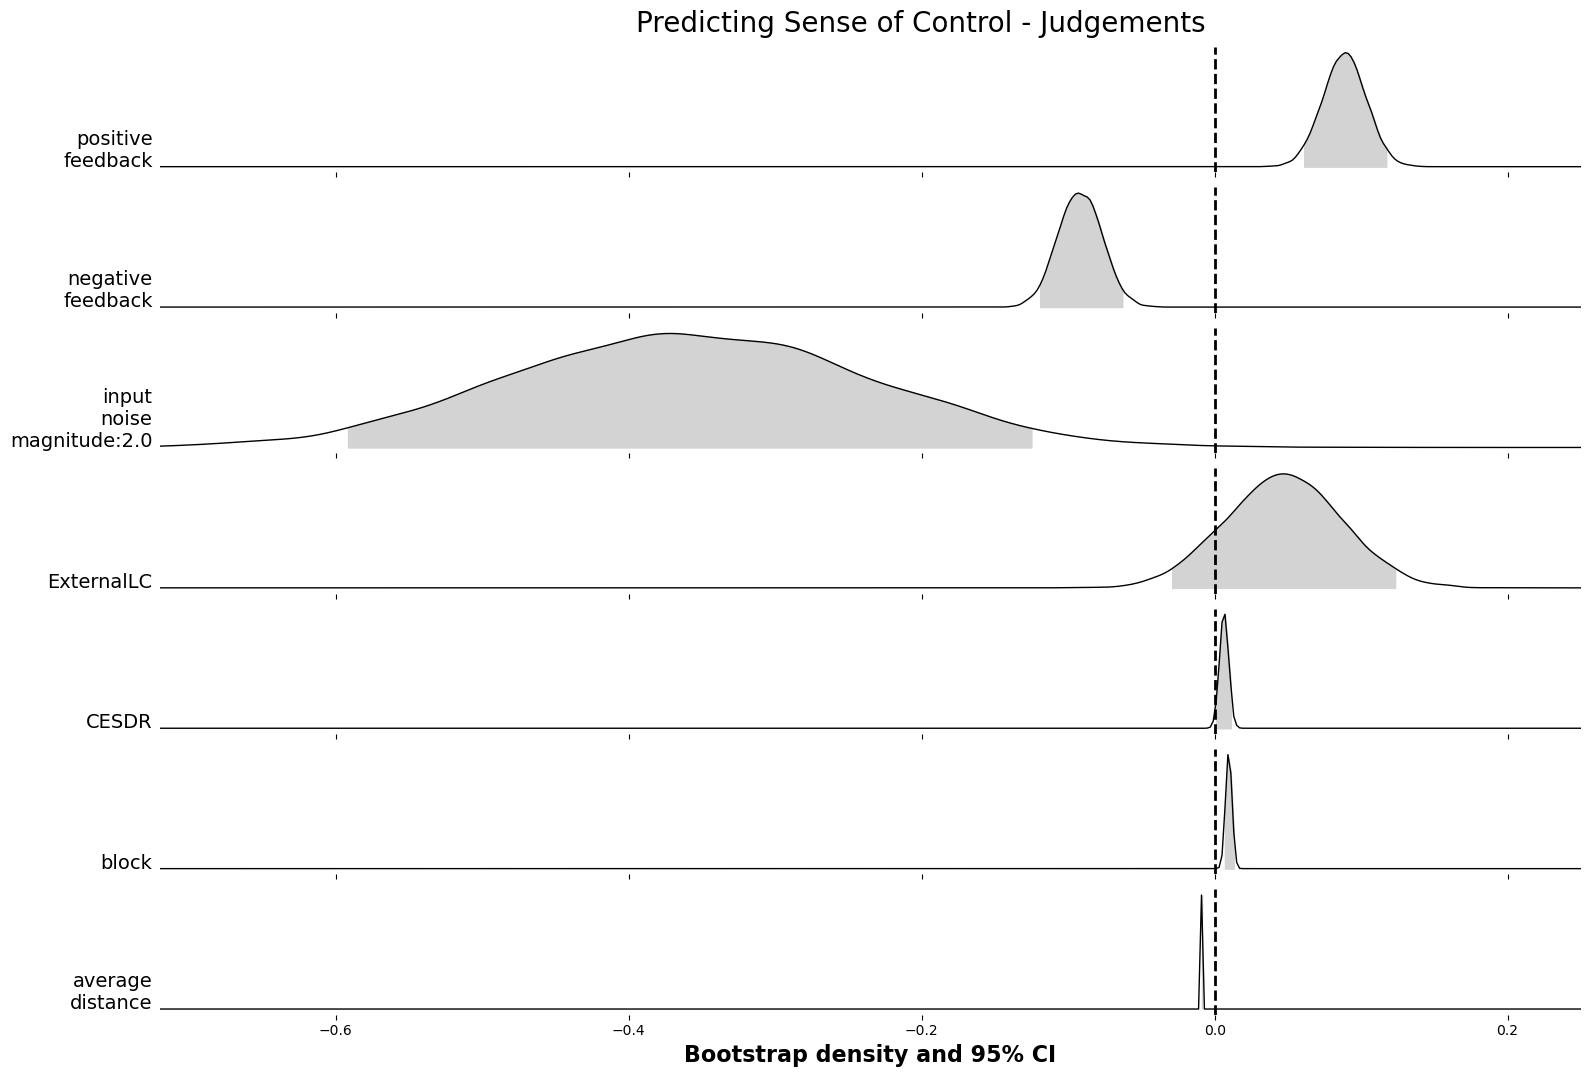

In [4]:
beta_labels = ['feedbackpositive', 'feedbacknegative', 'input_noise_magnitude2', 'ExternalLC', 'CESDR', 'block', 'avg_dist_trialwise']
covariates = ["positive feedback", "negative feedback", "input noise magnitude:2.0", "ExternalLC", "CESDR", "block", "average distance"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,10.5))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data[f"{beta_label}"])
    
    hpdi_bounds = az.hdi(x, 0.95)
    x_d = np.linspace(-1,1, 1000)
    kde = st.gaussian_kde(x)
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    ax_objs[-1].plot(x_d, kde(x_d), color="black", lw=1)
    ax_objs[-1].fill_between(x_d, kde(x_d), 
                             where=(x_d >= hpdi_bounds[0]) & (x_d <= hpdi_bounds[1]), 
                             alpha=1, color="lightgrey")


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.72,0.25)
    #ax_objs[-1].set_ylim(0,13.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ","\n")
    ax_objs[-1].text(-0.725,0,adj_covariate,fontweight="normal",fontsize=14,ha="right")


    i += 1

#gs.update(hspace=-0.7) # overlap

# title
fig.text(0.4, 1.0,"Predicting Sense of Control - Judgements",fontsize=20)

plt.tight_layout()
plt.savefig("SoCs_CIs_revised.svg", dpi=2000)

plt.show()

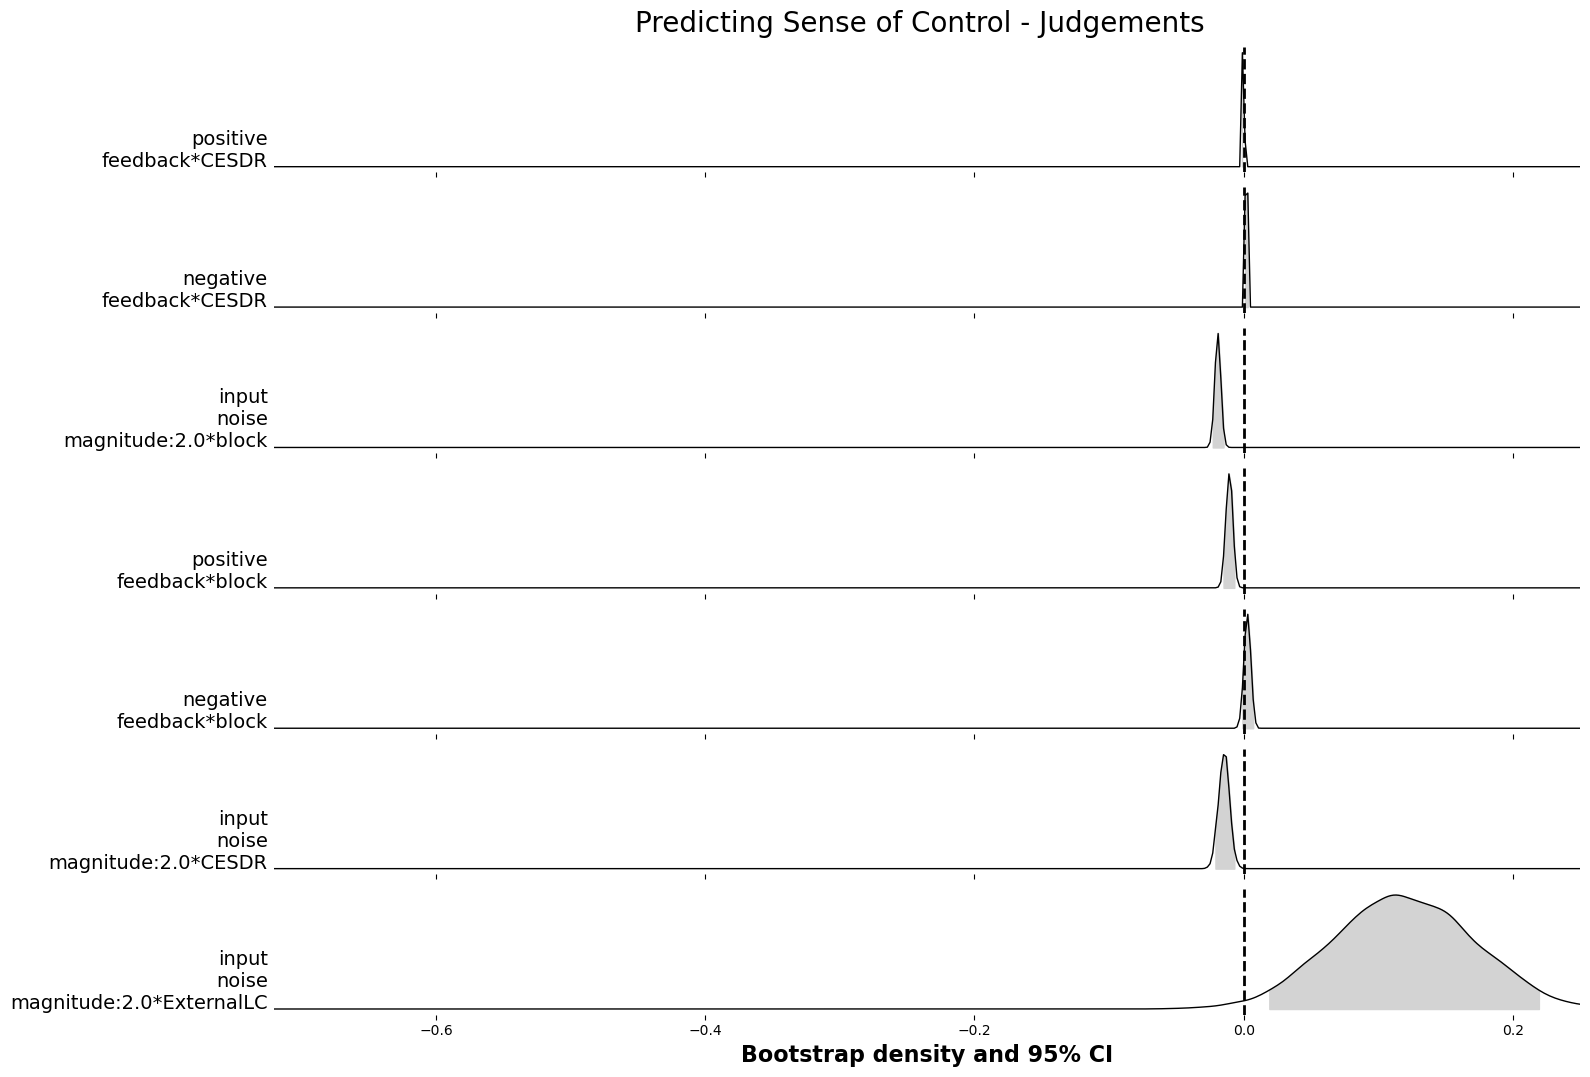

In [5]:
beta_labels = ['feedbackpositive:CESDR', 'feedbacknegative:CESDR', 'input_noise_magnitude2:block', 'feedbackpositive:block', 'feedbacknegative:block', 'input_noise_magnitude2:CESDR', 'input_noise_magnitude2:ExternalLC']
covariates = ["positive feedback*CESDR", "negative feedback*CESDR", "input noise magnitude:2.0*block", "positive feedback*block", "negative feedback*block", "input noise magnitude:2.0*CESDR", "input noise magnitude:2.0*ExternalLC"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,10.5))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data[f"{beta_label}"])
    
    hpdi_bounds = az.hdi(x, 0.95)
    x_d = np.linspace(-1,1, 1000)
    kde = st.gaussian_kde(x)
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    ax_objs[-1].plot(x_d, kde(x_d), color="black", lw=1)
    ax_objs[-1].fill_between(x_d, kde(x_d), 
                             where=(x_d >= hpdi_bounds[0]) & (x_d <= hpdi_bounds[1]), 
                             alpha=1, color="lightgrey")


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.72,0.25)
    #ax_objs[-1].set_ylim(0,13.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ","\n")
    ax_objs[-1].text(-0.725,0,adj_covariate,fontweight="normal",fontsize=14,ha="right")


    i += 1

#gs.update(hspace=-0.7) # overlap

# title
fig.text(0.4, 1.0,"Predicting Sense of Control - Judgements",fontsize=20)

plt.tight_layout()
plt.savefig("SoCs_CIs_interactions_revised.svg", dpi=2000)

plt.show()

In [3]:
bootstrap_data_performance = pd.read_csv("data/bootstrap_data_performance.csv")
bootstrap_data_performance

,obj,β1,β2,β3,β4,σ,σ1,σ2,ρ1,θ1,θ2,θ3
0,1317.413863,3.226260,0.593552,-0.019213,0.009826,0.252644,0.190333,0.131077,-0.814364,0.753364,-0.422510,0.301101
1,1282.170846,3.263855,0.578891,-0.020681,0.011183,0.252201,0.229551,0.145971,-0.893817,0.910191,-0.517331,0.259547
2,1262.311324,3.255232,0.603226,-0.019689,0.007806,0.252011,0.232231,0.159272,-0.919125,0.921511,-0.580888,0.248987
3,1294.841198,3.267289,0.588219,-0.020747,0.010539,0.252704,0.186359,0.132826,-0.906625,0.737460,-0.476541,0.221778
4,1308.557314,3.329269,0.543413,-0.021256,0.009979,0.252388,0.240639,0.170365,-0.912704,0.953448,-0.616086,0.275824
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1425.968982,3.233392,0.596706,-0.020242,0.010188,0.254082,0.209102,0.130509,-0.914045,0.822973,-0.469499,0.208342
9996,1559.755314,3.257348,0.561650,-0.023277,0.015424,0.255458,0.235550,0.143653,-0.931615,0.922069,-0.523879,0.204379
9997,1418.145598,3.278036,0.571816,-0.021879,0.013411,0.254099,0.238827,0.158633,-0.968376,0.939896,-0.604551,0.155758
9998,1276.243383,3.221538,0.601228,-0.020478,0.010498,0.251960,0.248564,0.149033,-0.875330,0.986521,-0.517751,0.286002


/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_11709/4093053198.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


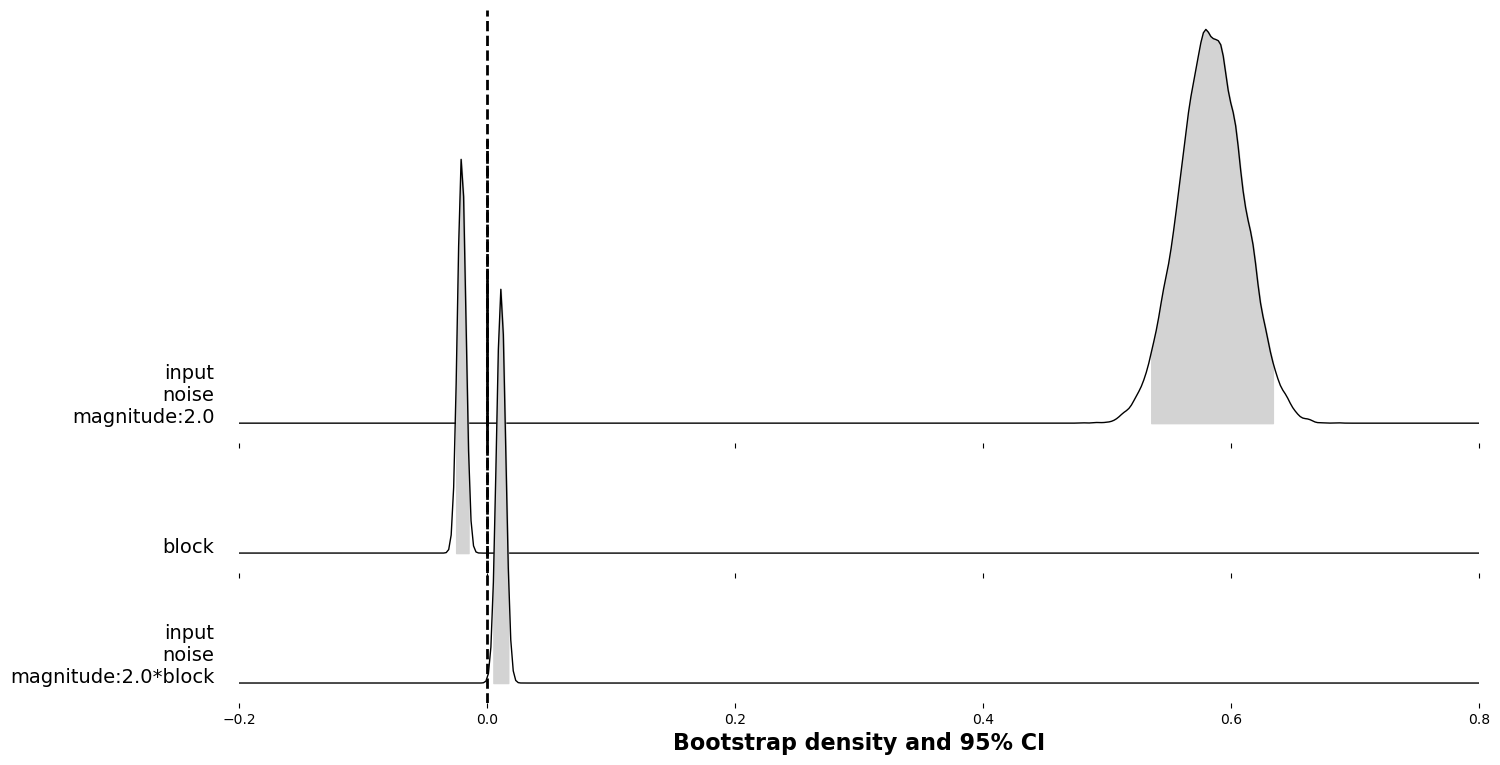

In [8]:
beta_labels = ['β2', 'β3', 'β4']
covariates = ["input noise magnitude:2.0", "block", "input noise magnitude:2.0*block"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data_performance[f"{beta_label}"])
    x_d = np.linspace(-1,1, 1000)

    kde = KernelDensity(bandwidth=0.003, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])
    
    # get 95%HDI bounds
    hdi_min, hdi_max = get_hdi(kde, x_d, hdi_prob=0.95)
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob), color="black", lw=1)
    #ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1, color="lightgrey")
    ax_objs[-1].fill_between(
        x_d, np.exp(logprob), where=(x_d >= hdi_min) & (x_d <= hdi_max),
        alpha=1, color="lightgrey")


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.2,0.8)
    #if i == 0:
    #    ax_objs[-1].set_ylim(0,10.3)
    #else:
    #    ax_objs[-1].set_ylim(0,13.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16, fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ", "\n")
    ax_objs[-1].text(-0.22,0, adj_covariate, fontweight="normal", fontsize=14, ha="right")


    i += 1

gs.update(hspace=-0.7)

#fig.text(0.07,0.85,"...",fontsize=20)

plt.tight_layout()
plt.show()

# Unidealized KDEs

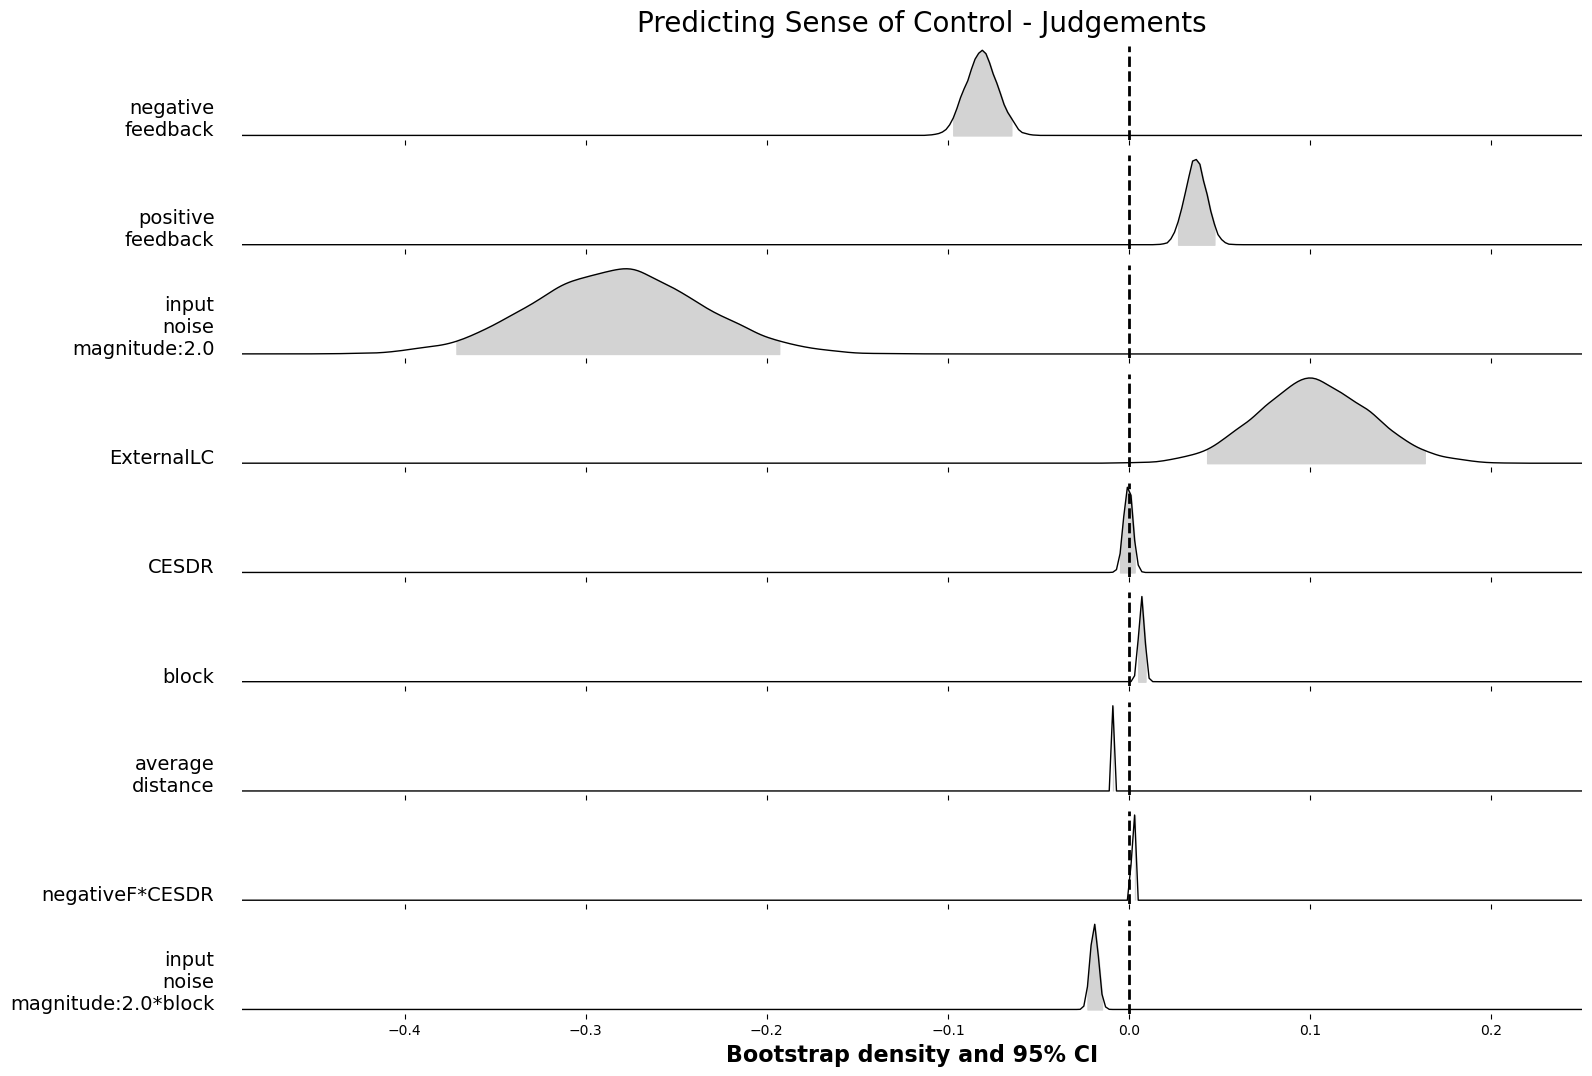

In [7]:
bootstrap_data = pd.read_csv("data/bootstrap_data_soc.csv")

beta_labels = ['β02', 'β03', 'β04', 'β05', 'β06', 'β07', 'β08', 'β09', 'β10']
covariates = ["negative feedback", "positive feedback", "input noise magnitude:2.0", "ExternalLC", "CESDR", "block", "average distance", "negativeF*CESDR", "input noise magnitude:2.0*block"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,10.5))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data[f"{beta_label}"])
    
    hpdi_bounds = az.hdi(x, 0.95)
    x_d = np.linspace(-1,1, 1000)
    kde = st.gaussian_kde(x)
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    ax_objs[-1].plot(x_d, kde(x_d), color="black", lw=1)
    ax_objs[-1].fill_between(x_d, kde(x_d), 
                             where=(x_d >= hpdi_bounds[0]) & (x_d <= hpdi_bounds[1]), 
                             alpha=1, color="lightgrey")


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.49,0.25)
    #ax_objs[-1].set_ylim(0,13.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ","\n")
    ax_objs[-1].text(-0.505,0,adj_covariate,fontweight="normal",fontsize=14,ha="right")


    i += 1

#gs.update(hspace=-0.7) # overlap

# title
fig.text(0.4, 1.0,"Predicting Sense of Control - Judgements",fontsize=20)

plt.tight_layout()
plt.savefig("SoCs_CIs.svg", dpi=2000)

plt.show()

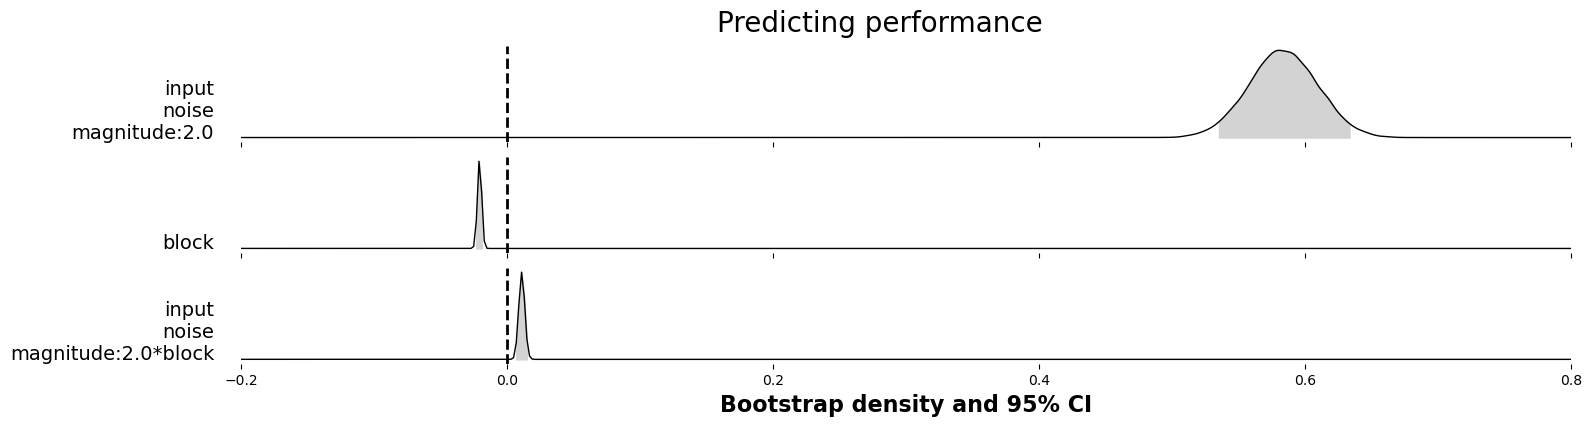

In [6]:
bootstrap_data_performance = pd.read_csv("data/bootstrap_data_performance.csv")

beta_labels = ['β2', 'β3', 'β4']
covariates = ["input noise magnitude:2.0", "block", "input noise magnitude:2.0*block"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,4))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data_performance[f"{beta_label}"])
    
    hpdi_bounds = az.hdi(x, 0.95)
    x_d = np.linspace(-1,1, 1000)
    kde = st.gaussian_kde(x)
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    ax_objs[-1].plot(x_d, kde(x_d), color="black", lw=1)
    ax_objs[-1].fill_between(x_d, kde(x_d), 
                             where=(x_d >= hpdi_bounds[0]) & (x_d <= hpdi_bounds[1]), 
                             alpha=1, color="lightgrey")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.2,0.8)
    #ax_objs[-1].set_ylim(0,15.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16, fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ", "\n")
    ax_objs[-1].text(-0.22,0, adj_covariate, fontweight="normal", fontsize=14, ha="right")

    i += 1

#gs.update(hspace=-0.7)

# title
fig.text(0.45, 1.0,"Predicting performance",fontsize=20)

plt.tight_layout()
plt.savefig("performance_CIs.svg", dpi=2000)

plt.show()